<a href="https://colab.research.google.com/github/mendrika-mdg/Nowcasting-IndabaX-Mendrika/blob/main/Tutorial_Mendrika_IndabaX_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IndabaX Madagascar**

# **Forecasting Thunderstorm Probability in the   Sofia   Region   Using   LSTM-Conv Models with Satellite Data**

# Sponsored by: [University of Leeds](https://www.leeds.ac.uk/), [WISER-EWSA and UK International Development](https://www.metoffice.gov.uk/services/government/international-development/weather-and-climate-information-services-wiser/wiser-africa/early-warnings-for-southern-africa-ewsa)

# Tutorial by Mendrika Rakotomanga


## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from tensorflow.keras.initializers import he_normal                                           # type: ignore
from tensorflow.keras.optimizers import Adam                                                  # type: ignore
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Conv2D                     # type: ignore
!pip install cartopy
import cartopy.crs as ccrs                                                                    # type: ignore
import cartopy.feature as cfeature                                                            # type: ignore
import warnings
warnings.filterwarnings("ignore")
import datetime

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?id=1PrGnzsBmvzoqcodJrAXCzPrpQpT0wMB6' -O 'test-data-input-t0.csv'
!wget --no-check-certificate 'https://drive.google.com/uc?id=1wassP6rasCoGW19A54zJCzBVHa1ySKnO' -O 'test-data-target-t0.npy'
!wget --no-check-certificate 'https://drive.google.com/uc?id=1rCHeYuEAQV8xYfP1Q2iqjXj3oitokbTV' -O 'test-data-target-t1.npy'
!wget --no-check-certificate 'https://drive.google.com/uc?id=1EdCfscTwMDsZsA9vp837DKhd_1E1gzij' -O 'train-data-input-t0.csv'
!wget --no-check-certificate 'https://drive.google.com/uc?id=1LBItYBVCPuhlzb81OW3osdYlasd64CSf' -O 'train-data-target-t1.npy'

--2024-12-14 08:29:49--  https://drive.google.com/uc?id=1PrGnzsBmvzoqcodJrAXCzPrpQpT0wMB6
Resolving drive.google.com (drive.google.com)... 142.250.101.138, 142.250.101.139, 142.250.101.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.101.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1PrGnzsBmvzoqcodJrAXCzPrpQpT0wMB6 [following]
--2024-12-14 08:29:49--  https://drive.usercontent.google.com/download?id=1PrGnzsBmvzoqcodJrAXCzPrpQpT0wMB6
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1711773 (1.6M) [application/octet-stream]
Saving to: ‘test-data-input-t0.csv’

test-data-input-t0. 100%[===================>]   1.63M  --.-KB/s    in 0.1s    

2024-12-14 08:29:52

## Import Datasets

In [ ]:
test_data_X = pd.read_csv("test-data-input-t0.csv")
test_data_y_lt1 = np.load("test-data-target-t1.npy")
test_data_y_lt0 = np.load("test-data-target-t0.npy")

In [ ]:
train_data_X = pd.read_csv("./train-data-input-t0.csv")
train_data_y_lt1 = np.load("./train-data-target-t1.npy")

In [ ]:
fract_storm_test = np.sum(test_data_y_lt1) / len(test_data_y_lt1.flatten())
fract_storm_train = np.sum(train_data_y_lt1) / len(train_data_y_lt1.flatten())

print(fract_storm_test)
print(fract_storm_train)

0.0667457627118644
0.07330178425162028


### Preprocessing

Scaling helps convergence faster

In [ ]:
# Define time periods and corresponding suffixes
time_periods = ["", "_30", "_60", "_90", "_120"]

# Define storm attributes to be scaled
attributes_to_scale = ["wp", "size", "ds"]

# Generate headers for attributes to scale across all time periods
to_scale = ",".join([
    f"{attr}{suffix}"
    for attr in attributes_to_scale
    for suffix in time_periods
    for i in range(1)
]).rstrip(',')

# Define base time headers
time_headers = ["year", "month", "day", "hour", "minute"]

# Generate headers for time variables across all time periods
t = ",".join([
    f"{col}{suffix}"
    for suffix in time_periods
    for col in time_headers
]).rstrip(',')

In [ ]:
def log_transform(df, keys):
    df_copy = df.copy()
    for key in keys:
        # Log transformation with handling for non-positive values
        df_copy[key] = np.where(df_copy[key] > 0, np.log(df_copy[key]), np.log(df_copy[key] + 1e-8))
    return df_copy

def sqrt_transform(df, keys):
    df_copy = df.copy()
    for key in keys:
        # Square root transformation with handling for negative values
        df_copy[key] = np.where(df_copy[key] >= 0, np.sqrt(df_copy[key]), df_copy[key])
    return df_copy

In [ ]:
def prepare(df):
    df = log_transform(df, to_scale.split(','))
    df = sqrt_transform(df, t.split(','))
    return df

In [ ]:
transform = True
if transform:
    train_X = prepare(train_data_X)
    test_X = prepare(test_data_X)

In [ ]:
train_X_t0, validation_X_t0, train_y_lt1, validation_y_lt1 = train_test_split(train_X, train_data_y_lt1, test_size=0.3, random_state=12)

### Scaling

In [ ]:
scaler = StandardScaler()
std_X_train = scaler.fit_transform(train_X_t0)
std_X_val = scaler.transform(validation_X_t0)
std_X_test = scaler.transform(test_X)

In [ ]:
x_train = std_X_train.reshape(len(std_X_train), 5, 10)
y_train = train_y_lt1

x_val = std_X_val.reshape(len(validation_X_t0), 5, 10)
y_val = validation_y_lt1

x_test = std_X_test.reshape(len(test_X), 5, 10)
y_test = test_data_y_lt1

In [ ]:
# Parameters for the output shape
resolution_y = 20  # Height of the output
resolution_x = 13  # Width of the output

# Model Definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(5, 10)),  # Input shape as specified (5 timesteps, 10 features)

    # LSTM layer with small units
    LSTM(16, activation="relu", return_sequences=False),  # 16 units for the LSTM

    # Dropout for regularization
    Dropout(0.2),

    # Dense layer to output the desired number of features
    Dense(resolution_y * resolution_x, activation='relu'),  # Output the desired number of units for (20, 13) output shape

    # Reshaping to the target resolution (20, 13)
    Reshape((resolution_y, resolution_x, 1)),  # Reshape to (20, 13, 1)

    # Convolutional layer with fewer filters
    Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal()),  # 16 filters

    # Output layer with 1 channel (since we need only 1 value per pixel)
    Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer=he_normal())  # Single channel output
])

# Model summary to check the number of parameters
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 16)                  │           1,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 260)                 │           4,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 20, 13, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 20, 13, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 20, 13, 1)           │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,325 (24.71 KB)

 Trainable params: 6,325 (24.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cl_thresholds = 0.2

METRICS = [
      tf.keras.metrics.MeanSquaredError(name='bs'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.Recall(name='recall', thresholds = cl_thresholds),
      tf.keras.metrics.Precision(name='precision', thresholds = cl_thresholds),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'),
      tf.keras.metrics.F1Score(name = 'f1_score',  threshold = cl_thresholds),
]

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc",
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
optimizer = Adam(clipvalue=1.0, learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.AUC(name='auc')])

In [ ]:
model_history = model.fit(x_train,
                          y_train,
                          epochs=500,
                          batch_size = 256,
                          callbacks = [early_stopping],
                          validation_data=(x_val, y_val)
                        )

Epoch 1/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - auc: 0.4942 - loss: 0.6864 - val_auc: 0.5080 - val_loss: 0.5866
Epoch 2/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.5156 - loss: 0.5538 - val_auc: 0.5561 - val_loss: 0.4338
Epoch 3/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.5644 - loss: 0.3557 - val_auc: 0.7800 - val_loss: 0.2264
Epoch 4/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.7822 - loss: 0.2248 - val_auc: 0.8060 - val_loss: 0.2185
Epoch 5/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.8035 - loss: 0.2189 - val_auc: 0.8157 - val_loss: 0.2154
Epoch 6/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.8120 - loss: 0.2170 - val_auc: 0.8222 - val_loss: 0.2130
Epoch 7/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.8180 - loss: 0.2145 - val_auc: 0.8267 - val_loss: 0.2113
Epoch 8/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.8228 - loss: 0.2122 - val_auc: 0.8306 - val_loss: 0.2098
Epoch 9/500
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.82

In [ ]:
pred_y_train = model.predict(x_train).flatten()
pred_y_test = model.predict(x_test).flatten()

541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = metrics.roc_curve(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False alarm [%]')
  plt.ylabel('Hit [%]')
  plt.xlim([0,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
auc_train = roc_auc_score(y_train.flatten(), pred_y_train)
auc_test = roc_auc_score(y_test.flatten(), pred_y_test)

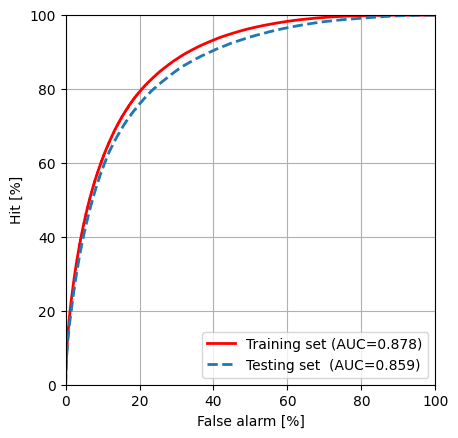

In [ ]:
plot_roc(f"Training set (AUC={auc_train:.3f})", y_train.flatten(), pred_y_train.flatten(), color="red")
plot_roc(f"Testing set  (AUC={auc_test:.3f})", y_test.flatten(), pred_y_test.flatten(), linestyle='--')
plt.legend(loc='lower right');

### Reliability diagram

In [ ]:
def reliability_curve(y, y_pred, bin_size=0.1, count_pred_per_bin=100):
  y = np.array(y)
  y_pred = np.array(y_pred)
  bins = np.arange(0, 1+bin_size, bin_size)
  bin_centers = [(b1 + b2) / 2 for b1, b2 in zip(bins[:-1], bins[1:])]
  prop_positive = []
  bin_center_ax = []
  no_pred_per_bin = []
  for b1, b2, bc in zip(bins[:-1], bins[1:], bin_centers):
    in_bin = np.logical_and(y_pred >= b1, y_pred < b2)
    no_predictions_per_bin = np.sum(in_bin)
    no_positive_per_bin = np.sum(y[in_bin])
    if no_predictions_per_bin > count_pred_per_bin:
      prop_pos = round(no_positive_per_bin/no_predictions_per_bin, 3)
      prop_positive.append(prop_pos)
      bin_center_ax.append(round(bc, 3))
      no_pred_per_bin.append(no_predictions_per_bin)
    else:
      continue
  return bin_center_ax, prop_positive, no_pred_per_bin

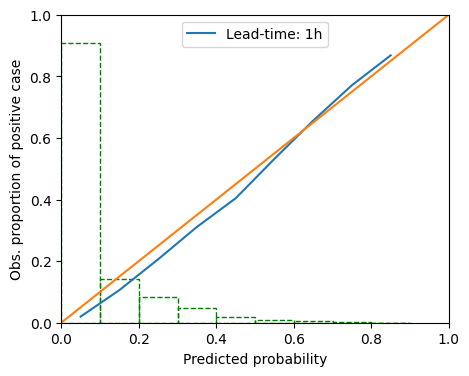

In [ ]:
prob_pred, prob_true, no_pred_per_bin = reliability_curve(y_test.flatten(), pred_y_test.flatten())
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, label=f"Lead-time: 1h")

plt.xlabel("Predicted probability")
plt.ylabel("Obs. proportion of positive case")

no_pred_per_bin = [i/(1.1*np.max(no_pred_per_bin)) for i in no_pred_per_bin]
plt.plot(np.arange(0,1.2,0.2), np.arange(0,1.2,0.2))
plt.bar(prob_pred, no_pred_per_bin, width=0.1, linestyle="--", fill=False, edgecolor="green")

plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='upper center')
plt.show()

## Plotting

In [ ]:
index_display = 0

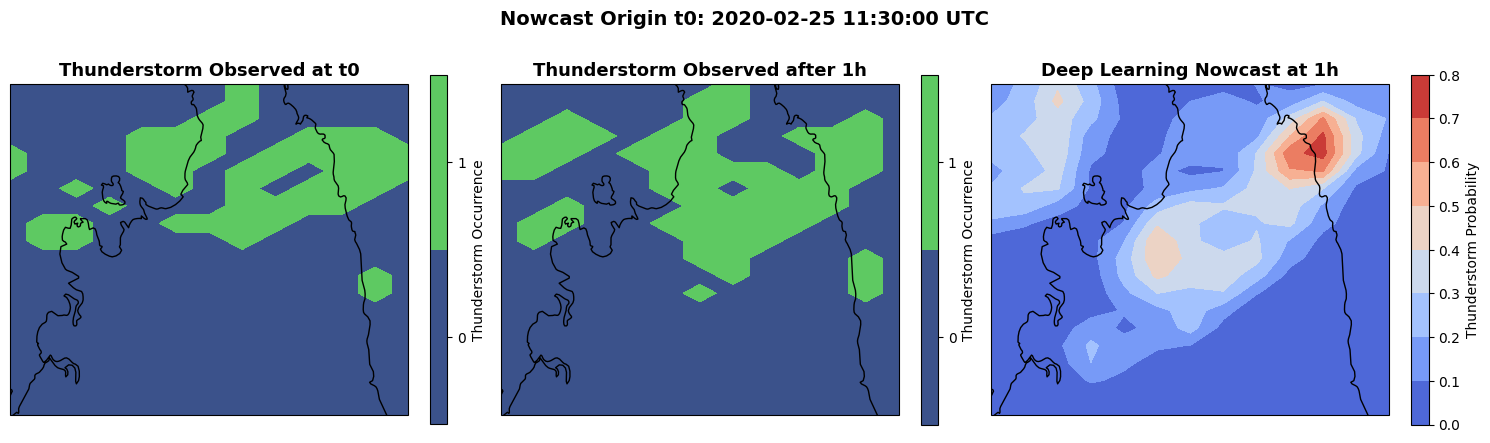

In [ ]:
# Parameters
extent = (47.5, 50.5, -15, -12.5)
lon_min, lon_max, lat_min, lat_max = extent
n_rows, n_cols = 20, 13  # Number of latitude points and longitude points

# Create linearly spaced values for latitudes and longitudes and create meshgrids
latitudes = np.linspace(lat_min, lat_max, n_rows)
longitudes = np.linspace(lon_min, lon_max, n_cols)
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Index for data to display
to_display = [
    test_data_y_lt0[index_display],  # Add new data here
    y_test[index_display],
    pred_y_test.reshape(len(y_test), n_rows, n_cols)[index_display],
]
titles = ["Thunderstorm Observed at t0", "Thunderstorm Observed after 1h", "Deep Learning Nowcast at 1h"]

colormaps = ["viridis", "viridis", "coolwarm"]  # Add colormap for the new subplot

# Create three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop through the axes to plot each subplot
for i, ax in enumerate(axes):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, edgecolor='gray')
    ax.tick_params(bottom=True, left=True, top=False, right=False)

    # Plot data with appropriate colormap
    if i == 0 or i == 1:  # True Binary target
        contour = ax.contourf(
            lon_grid, lat_grid, to_display[i], transform=ccrs.PlateCarree(), cmap=colormaps[i], levels=[-0.5, 0.5, 1.5]
        )
        # Add discrete colorbar
        cbar = fig.colorbar(contour, ax=ax, orientation='vertical', fraction=0.04, pad=0.05, ticks=[0, 1])
        cbar.set_label("Thunderstorm Occurrence")
        cbar.ax.set_yticklabels(["0", "1"])

    else:  # Continuous or additional data target
        contour = ax.contourf(
            lon_grid, lat_grid, to_display[i], transform=ccrs.PlateCarree(), cmap=colormaps[i]
        )
        # Add continuous colorbar
        cbar = fig.colorbar(contour, ax=ax, orientation='vertical', fraction=0.04, pad=0.05)
        cbar.set_label("Probability" if i == 1 else "Thunderstorm Probability")

    ax.set_title(titles[i], fontsize=13, fontweight='bold')

# Adjust layout and display
plt.tight_layout()


data_display = test_data_X.iloc[index_display]
year = int(data_display["year_120"])
month = int(data_display["month_120"])
day = int(data_display["day_120"])
hour = int(data_display["hour_120"])
minute = int(data_display["minute_120"])

# Create a datetime object
nowcast_origin = datetime.datetime(year, month, day, hour, minute)
plt.suptitle(f"Nowcast Origin t0: {nowcast_origin} UTC", fontsize=14, fontweight='bold')
plt.show()

### Fraction Skill Score

In [ ]:
import numpy as np
from scipy.ndimage import uniform_filter

def compute_fss(observation, prediction, threshold=0.5, neighborhood_size=3):
    """
    Compute the Fraction Skill Score (FSS) for an observation and prediction.

    Parameters:
        observation (np.ndarray): Ground truth binary field (2D array).
        prediction (np.ndarray): Predicted binary field (2D array).
        threshold (float): Threshold to binarize the observation and prediction.
        neighborhood_size (int): Size of the moving window for fraction computation.

    Returns:
        float: Fraction Skill Score (FSS).
    """
    # Binarize observation and prediction
    obs_binary = (observation >= threshold).astype(float)
    pred_binary = (prediction >= threshold).astype(float)

    # Compute fractions using a uniform filter for the neighborhood
    obs_fraction = uniform_filter(obs_binary, size=neighborhood_size, mode='constant')
    pred_fraction = uniform_filter(pred_binary, size=neighborhood_size, mode='constant')

    # Compute the Mean Squared Error (MSE)
    mse = np.mean((obs_fraction - pred_fraction) ** 2)

    # Compute the reference MSE (MSE_ref)
    mse_ref = np.mean(obs_fraction ** 2 + pred_fraction ** 2)

    # Compute the Fraction Skill Score (FSS)
    fss = 1 - mse / mse_ref

    return fss

In [ ]:
compute_fss(y_test[index_display], pred_y_test.reshape(len(y_test), n_rows, n_cols)[index_display])

0.1886928339935181